# Step1 Brief discription

We recognize the works of artists through their unique style, such as color choices or brush strokes. The “je ne sais quoi” of artists like Claude Monet can now be imitated with algorithms thanks to generative adversarial networks (GANs). In this getting started competition, you will bring that style to your photos or recreate the style from scratch!

A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.

We recommend using TFRecords as a Getting Started competition is a great way to become more familiar with a new data format, but JPEG images have also been provided.

The monet directories contain Monet paintings. Use these images to train your model.

The photo directories contain photos. 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np
import re
import os
from PIL import Image

In [2]:
monet_jpg_path = r'E:\Jia\Desktop\MS-DS\5511 Introduction to Deep Learning\week5\assessment\gan-getting-started\monet_jpg'
photo_jpg_path = r'E:\Jia\Desktop\MS-DS\5511 Introduction to Deep Learning\week5\assessment\gan-getting-started\photo_jpg'

In [3]:
IMAGE_SIZE = [256, 256]
batch_size = 1
output_channels = 3

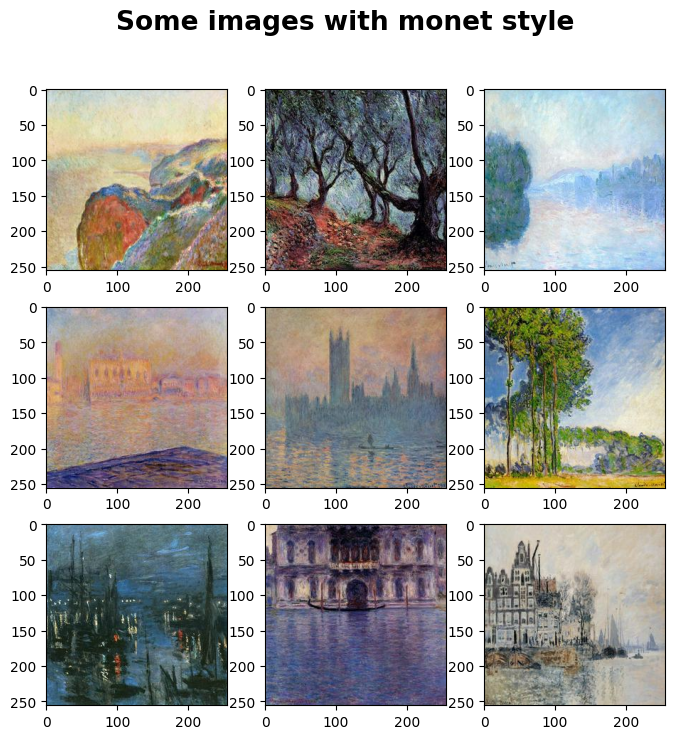

In [4]:
_, ax = plt.subplots(3,3, figsize=(8,8))
plt.suptitle('Some images with monet style', fontsize=19, fontweight='bold')

ind = 0 
for k in range(3):
    for kk in range(3):
        ax[k][kk].imshow(Image.open('E:/Jia/Desktop/MS-DS/5511 Introduction to Deep Learning/week5/assessment/gan-getting-started/monet_jpg/' +os.listdir(monet_jpg_path)[ind]))
        ind += 1

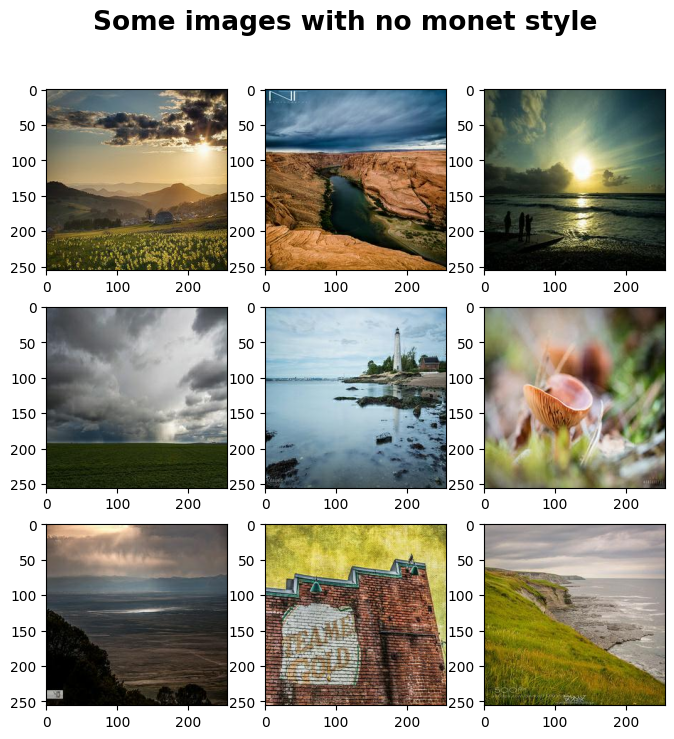

In [5]:
_, ax = plt.subplots(3,3, figsize=(8,8))
plt.suptitle('Some images with no monet style', fontsize=19, fontweight='bold')

ind = 0 
for k in range(3):
    for kk in range(3):
        ax[k][kk].imshow(Image.open('E:/Jia/Desktop/MS-DS/5511 Introduction to Deep Learning/week5/assessment/gan-getting-started/photo_jpg/' +os.listdir(photo_jpg_path)[ind]))
        ind += 1

In [6]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.10.0


# Step2 Exploratory data analysis
## 2.1 Transform dataset into TFRecord format

All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

Thanks to https://www.kaggle.com/code/artyomivanov/monet-cyclegan

In [7]:
monet_tfrec_path = r'E:\Jia\Desktop\MS-DS\5511 Introduction to Deep Learning\week5\assessment\gan-getting-started\monet_tfrec\*.tfrec'
photo_tfrec_path = r'E:\Jia\Desktop\MS-DS\5511 Introduction to Deep Learning\week5\assessment\gan-getting-started\photo_tfrec\*.tfrec'

In [8]:
MONET_FILENAMES = tf.io.gfile.glob(str(monet_tfrec_path))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(photo_tfrec_path))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [9]:
IMAGE_SIZE = [256, 256]
# create decode_image function to decode a JPEG-encoded image
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

# function read_tfrecord to parse a single example photo
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [11]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [12]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

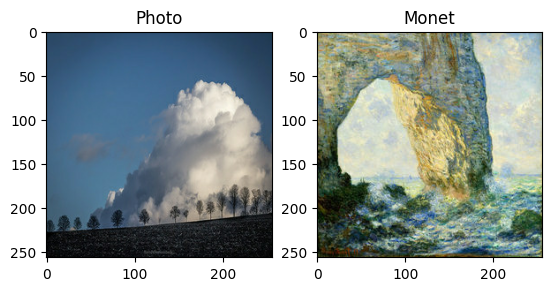

In [17]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

# Step3 Cyclegan model
## 3.1 Build the discriminator

In [18]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    model = keras.Sequential()
    model.add(layers.Conv2D(64,4,strides=2, padding='same', kernel_initializer=initializer, activation='relu', input_shape=[256,256,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(128,4,strides=2, padding='same', kernel_initializer=initializer, activation='relu',use_bias=False))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(256,4,strides=2, padding='same', kernel_initializer=initializer, activation='relu',use_bias=False))
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(1,4,strides=1, padding='valid', kernel_initializer=initializer, activation='relu',use_bias=False))
    return model

## 3.2 Build the generator

In [19]:
def Generator():
    initializer = tf.random_normal_initializer(0., 0.02)
    model = keras.Sequential()
    model.add(layers.Conv2D(64,4,strides=2, padding='same', kernel_initializer=initializer, activation='relu', input_shape=[256,256,3]))
    model.add(layers.Conv2D(128,4,strides=2, padding='same', kernel_initializer=initializer, activation='relu',use_bias=False))
    model.add(layers.Conv2D(256,4,strides=2, padding='same', kernel_initializer=initializer, activation='relu',use_bias=False))
    model.add(layers.Conv2D(512,4, strides=2, padding='same', kernel_initializer=initializer, activation='relu',use_bias=False))       
    model.add(layers.Conv2DTranspose(256, 4, strides=2,padding='same', kernel_initializer=initializer, activation='relu', use_bias=False))          
    model.add(layers.Conv2DTranspose(128, 4, strides=2,padding='same', kernel_initializer=initializer, activation='relu', use_bias=False))          
    model.add(layers.Conv2DTranspose( 64, 4, strides=2,padding='same', kernel_initializer=initializer, activation='relu', use_bias=False))          
    model.add(layers.Conv2DTranspose(  3, 4, strides=2,padding='same', kernel_initializer=initializer, activation='tanh', use_bias=False))          
    return model

In [20]:
with strategy.scope():
    monet_generator = Generator() # transforms photos to Monet-esque paintings
    photo_generator = Generator() # transforms Monet paintings to be more like photos

    monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = Discriminator() # differentiates real photos and generated photos

## 3.3 Built CycleGan class

In [21]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
            
            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)
        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## 3.4 Define loss function

In [22]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [23]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [24]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [25]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

## 3.5 Train the CycleGan

In [26]:
with strategy.scope():
    learning_rate = 3e-4
    monet_generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.3)
    photo_generator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.3)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.3)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.3)

In [27]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [28]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25
)

Epoch 1/25
300/300 [==============================] - 81s 243ms/step - monet_gen_loss: 7.3847 - photo_gen_loss: 7.5510 - monet_disc_loss: 0.5648 - photo_disc_loss: 0.5056
Epoch 2/25
300/300 [==============================] - 78s 259ms/step - monet_gen_loss: 6.1112 - photo_gen_loss: 6.2242 - monet_disc_loss: 0.5342 - photo_disc_loss: 0.5014
Epoch 3/25
300/300 [==============================] - 78s 261ms/step - monet_gen_loss: 5.8559 - photo_gen_loss: 5.9485 - monet_disc_loss: 0.5842 - photo_disc_loss: 0.5134
Epoch 4/25
300/300 [==============================] - 78s 260ms/step - monet_gen_loss: 5.6347 - photo_gen_loss: 5.7088 - monet_disc_loss: 0.5926 - photo_disc_loss: 0.6508
Epoch 5/25
300/300 [==============================] - 78s 259ms/step - monet_gen_loss: 5.4720 - photo_gen_loss: 5.4878 - monet_disc_loss: 0.6774 - photo_disc_loss: 0.6433
Epoch 6/25
300/300 [==============================] - 78s 259ms/step - monet_gen_loss: 5.1451 - photo_gen_loss: 5.1163 - monet_disc_loss: 0.6931 

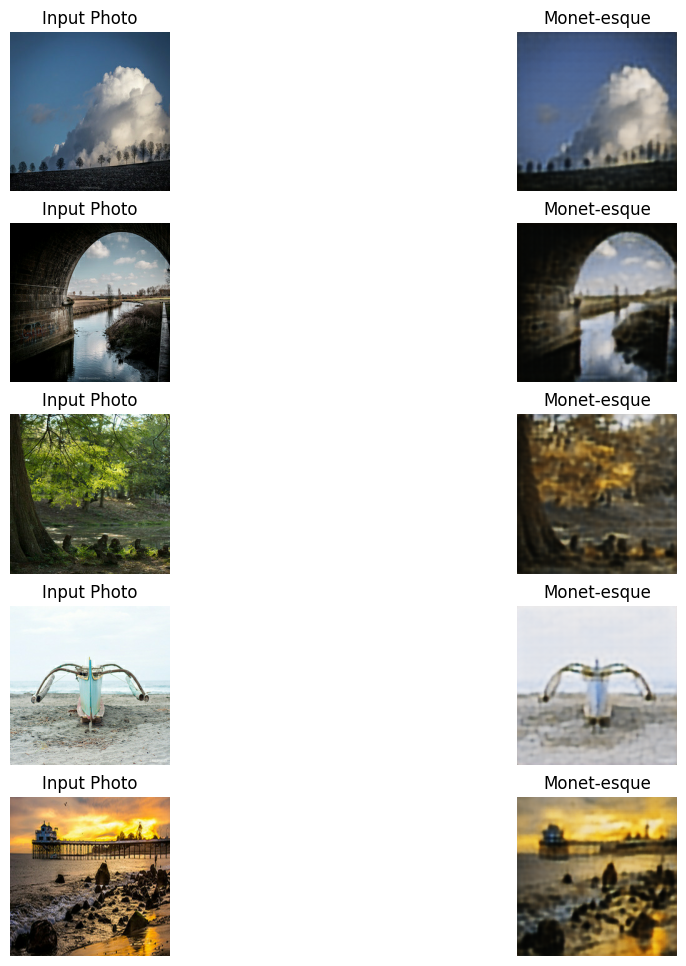

In [29]:
_, ax = plt.subplots(5, 2, figsize=(12,12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [187]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=50
)

Epoch 1/50
300/300 [==============================] - 74s 246ms/step - monet_gen_loss: 3.6762 - photo_gen_loss: 3.6469 - monet_disc_loss: 0.6977 - photo_disc_loss: 0.6931
Epoch 2/50
300/300 [==============================] - 79s 263ms/step - monet_gen_loss: 3.6523 - photo_gen_loss: 3.6214 - monet_disc_loss: 0.6931 - photo_disc_loss: 0.6931
Epoch 3/50
300/300 [==============================] - 79s 264ms/step - monet_gen_loss: 3.5877 - photo_gen_loss: 3.5527 - monet_disc_loss: 0.6931 - photo_disc_loss: 0.6931
Epoch 4/50
300/300 [==============================] - 79s 262ms/step - monet_gen_loss: 3.5952 - photo_gen_loss: 3.5639 - monet_disc_loss: 0.6931 - photo_disc_loss: 0.6931
Epoch 5/50
300/300 [==============================] - 78s 261ms/step - monet_gen_loss: 3.6034 - photo_gen_loss: 3.5685 - monet_disc_loss: 0.6931 - photo_disc_loss: 0.6931
Epoch 6/50
300/300 [==============================] - 78s 261ms/step - monet_gen_loss: 3.5903 - photo_gen_loss: 3.5625 - monet_disc_loss: 0.6931 

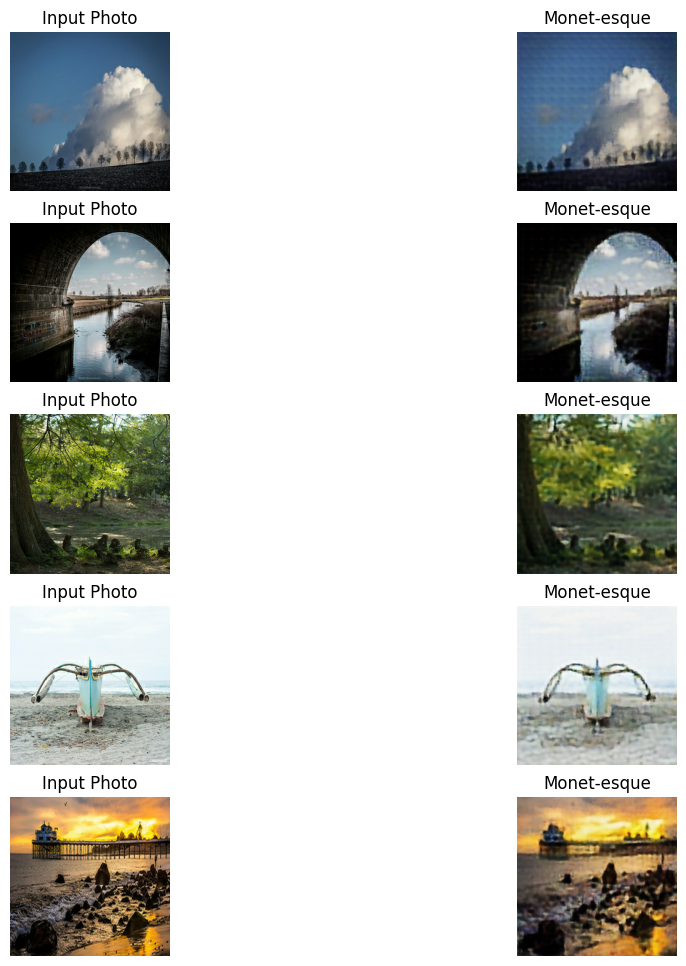

In [189]:
_, ax = plt.subplots(5, 2, figsize=(12,12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Step4 Results and  analysis

In this project, I tried a cycle gan model to generate Monet-style images.  The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec 300 Monet paintings sized 256x256 in TFRecord format,  and monet_jpg 300 Monet paintings sized 256x256 in JPEG format, and the photo_tfrec contains 7028 photos sized 256x256 in TFRecord format, and photo_jpg  7028 photos sized 256x256 in JPEG format.

First, import the dataset and transform the dataset into TFRecord format. All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

Then, built a cycle gan model. A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator. The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images. I built the discriminator,  the generator, and the cyclegan class, and defined the loss function. I tried two different epochs value to optimize the model,  according to the outputting pictures, we can see the second group with epochs is equal to 50 is much better than first group which 25 epochs in terms of color and clarity.

# Step5 Conclusion

During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. We want the original photo and the twice-transformed photo to be similar to one another. We can optimize the model by hyperparameter tunning, in the further study, I am going to increase the epoch values and modify the generator and discriminator model, such as apply to different activation, and kernel_initializer.